В этом кейсе мы познакомимся с тем, как проводить EDA на примере исследования о качестве шоколадных батончиков. EDA поможет нам первично проверить гипотезу о связи различных переменных с рейтингом батончика.

В датасете представлены следующие данные:

Bar id — ID батончика в базе данных
Company (Maker-if known) — название компании, изготовившей батончик.
Specific Bean Origin or Bar Name — точное место происхождения какао-бобов.
Broad Bean Origin — название региона, где были выращены какао-бобы.
Company Location — страна, в которой произведён шоколадный батончик.
Bean Type — вид какао-бобов, используемых в батончике.
REF — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.
Review Date — год публикации рецензии.
Cocoa Percent — процент какао в шоколаде.
Rating — оценка батончика фокус-группой.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

cacao = pd.read_csv('cacao_flavors.csv')
display(cacao.head(10))
cacao.info() 

,Bar id,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,1,A. Morin,Agua Grande,1876,2016,63%,France,11.50,,Sao Tome
1,2,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,3,A. Morin,Atsane,1676,2015,670%,France,3.00,,Togo
3,4,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,5,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
5,6,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela
6,7,A. Morin,Cuba,1315,2014,70%,France,3.50,,Cuba
7,8,A. Morin,Sur del Lago,1315,2014,70%,France,11.50,Criollo,Venezuela
8,9,,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela
9,10,A. Morin,Pablino,1319,2014,70%,France,4.00,,Peru


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 10 columns):
Bar id                              1795 non-null int64
Company 
(Maker-if known)           1795 non-null object
Specific Bean Origin
or Bar Name    1795 non-null object
REF                                 1795 non-null int64
Review
Date                         1795 non-null int64
Cocoa
Percent                       1795 non-null object
Company
Location                    1795 non-null object
Rating                              1795 non-null float64
Bean
Type                           1794 non-null object
Broad Bean
Origin                   1794 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 140.4+ KB


In [37]:
cacao.columns = (['bar_id', 
                  'company', 
                  'specific_origin', 
                  'ref', 'review_date', 
                  'cocoa_percent', 
                  'company_location', 
                  'rating',
                  'bean_type',
                  'broad_origin'])
cacao.columns

Index(['bar_id', 'company', 'specific_origin', 'ref', 'review_date',
       'cocoa_percent', 'company_location', 'rating', 'bean_type',
       'broad_origin'],
      dtype='object')

1795


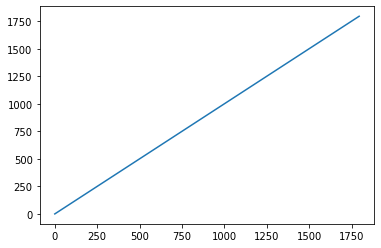

In [38]:
print(cacao.bar_id.nunique())
plt.plot(cacao.bar_id)

In [39]:
cacao.drop(['bar_id'], inplace = True, axis = 1) # remove column (nothing interesting)

In [40]:
pd.DataFrame(cacao.company.value_counts())

,company
,99
Soma,45
Fresco,26
Bonnat,26
Pralus,25
...,...
Loiza,1
Jacque Torres,1
Tobago Estate (Pralus),1
Green Bean to Bar,1


In [41]:
cacao.company = cacao.company.apply(lambda x: None if x.strip() == '' else x) # replace empty cell with None

display(pd.DataFrame(cacao.company.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:"#Число 10 взято для ориентира, можно брать другое
      , (cacao.company.value_counts()>10).sum())
cacao.loc[:, ['company']].info()

,company
Soma,45
Fresco,26
Bonnat,26
Pralus,25
Domori,22
...,...
To'ak (Ecuatoriana),1
Jordis,1
Condor,1
Cacaosuyo (Theobroma Inversiones),1


Значений, встретившихся в столбце более 10 раз: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 1 columns):
company    1696 non-null object
dtypes: object(1)
memory usage: 14.1+ KB


In [42]:
pd.DataFrame(cacao.specific_origin.value_counts())

,specific_origin
,58
Madagascar,55
Peru,44
Ecuador,39
Dominican Republic,33
...,...
"Maranon, Joya Rara",1
"Guasare, La Sierra de Perija, batch gua001",1
Colombian Dark,1
2009 Hapa Nibby,1


In [43]:
cacao.specific_origin = cacao.specific_origin.apply(lambda x: None if x.strip() == '' else x) # replace empty cell with None

display(pd.DataFrame(cacao.specific_origin.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:"#Число 10 взято для ориентира, можно брать другое
      , (cacao.specific_origin.value_counts()>10).sum())
cacao.loc[:, ['specific_origin']].info()

,specific_origin
Madagascar,55
Peru,44
Ecuador,39
Dominican Republic,33
Venezuela,21
...,...
"Maranon, Joya Rara",1
"Guasare, La Sierra de Perija, batch gua001",1
Colombian Dark,1
2009 Hapa Nibby,1


Значений, встретившихся в столбце более 10 раз: 15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 1 columns):
specific_origin    1737 non-null object
dtypes: object(1)
memory usage: 14.1+ KB


count    1795.000000
mean     1035.904735
std       552.886365
min         5.000000
25%       576.000000
50%      1069.000000
75%      1502.000000
max      1952.000000
Name: ref, dtype: float64

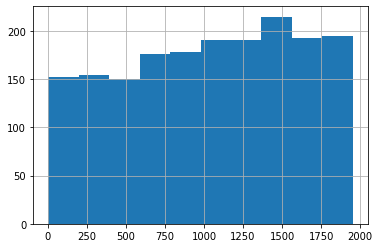

In [44]:
cacao.ref.hist()
cacao.ref.describe()

count    1795.000000
mean     2012.325348
std         2.927210
min      2006.000000
25%      2010.000000
50%      2013.000000
75%      2015.000000
max      2017.000000
Name: review_date, dtype: float64

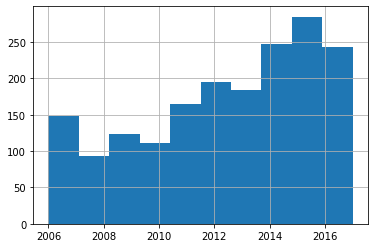

In [45]:
cacao.review_date.hist()
cacao.review_date.describe()

In [46]:
cacao.cocoa_percent

0        63%
1        70%
2       670%
3        70%
4        70%
        ... 
1790     70%
1791     65%
1792     65%
1793     62%
1794     65%
Name: cocoa_percent, Length: 1795, dtype: object

In [47]:
# Значения в столбцах представлены в виде процентов. 
# Для дальнейшего анализа будет проще, если они будут представлены числами. 
# Трансформируем столбец
cacao.cocoa_percent = cacao.cocoa_percent.apply(lambda x: float(x.replace('%', '')))

count    1795.000000
mean       75.932312
std        44.475981
min        42.000000
25%        70.000000
50%        70.000000
75%        75.000000
max       682.000000
Name: cocoa_percent, dtype: float64

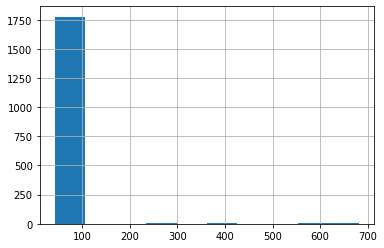

In [48]:
cacao.cocoa_percent.hist()
cacao.cocoa_percent.describe()

Видим, что основное распределение лежит между  и  процентами и есть потенциальные выбросы свыше % (об этом нам говорит здравый смысл).
Самый простой способ отфильтровать выбросы — воспользоваться формулой интерквартильного расстояния (межквартильного размаха). Выбросом считаются такие значения, которые лежат вне рамок

percentile(25) -1.5*IQR : percentile(75)+1.5*IQR,
где IQR = percentile(75) - percentile(25).

25-й перцентиль: 70.0, 75-й перцентиль: 75.0, IQR: 5.0,  Границы выбросов: [62.5, 82.5].


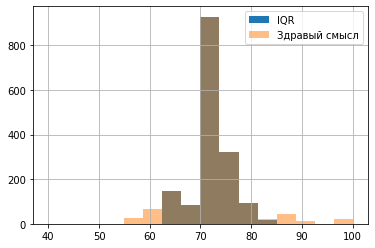

In [49]:
median = cacao.cocoa_percent.median()
IQR = cacao.cocoa_percent.quantile(0.75) - cacao.cocoa_percent.quantile(0.25)
perc25 = cacao.cocoa_percent.quantile(0.25)
perc75 = cacao.cocoa_percent.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

cacao.cocoa_percent.loc[cacao.cocoa_percent.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16
                                                                                              , range = (40, 100), 
                                                                                             label = 'IQR')
cacao.cocoa_percent.loc[cacao.cocoa_percent <= 100].hist(alpha = 0.5, bins = 16, range = (40, 100),
                                                        label = 'Здравый смысл')
plt.legend();

In [51]:
cacao = cacao.loc[cacao.cocoa_percent <= 100]
cacao

,company,specific_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,11.50,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru
5,A. Morin,Carenero,1315,2014,70.0,France,2.75,Criollo,Venezuela
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.0,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65.0,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.0,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.0,Austria,3.25,,India


In [52]:
cacao.company_location

0        France
1        France
3        France
4        France
5        France
         ...   
1790    Austria
1791    Austria
1792    Austria
1793    Austria
1794    Austria
Name: company_location, Length: 1776, dtype: object

In [53]:
display(pd.DataFrame(cacao.company_location.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.company_location.value_counts()>10).sum())
cacao.loc[:, ['company_location']].info()

,company_location
U.S.A.,756
France,155
Canada,124
U.K.,94
Italy,63
...,...
Philippines,1
India,1
Suriname,1
Russia,1


Значений, встретившихся в столбце более 10 раз: 22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 0 to 1794
Data columns (total 1 columns):
company_location    1776 non-null object
dtypes: object(1)
memory usage: 27.8+ KB


In [54]:
cacao.rating

0       11.50
1        2.75
3        3.50
4        3.50
5        2.75
        ...  
1790     3.75
1791     3.00
1792     3.50
1793     3.25
1794     3.00
Name: rating, Length: 1776, dtype: float64

count    1776.000000
mean        3.425816
std         1.759007
min         1.000000
25%         3.000000
50%         3.250000
75%         3.500000
max        19.750000
Name: rating, dtype: float64

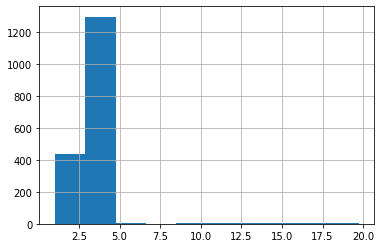

In [57]:
cacao.rating.hist()
cacao.rating.describe()

25-й перцентиль: 3.0, 75-й перцентиль: 3.5, IQR: 0.5,  Границы выбросов: [2.25, 4.25].


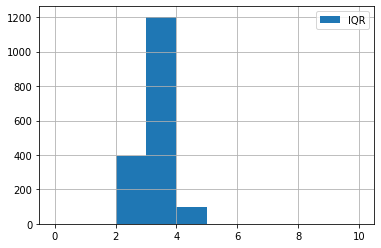

In [58]:
median = cacao.rating.median()
IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
cacao.rating.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), 
                                                                                             label = 'IQR')
plt.legend();

In [59]:
cacao = cacao.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

In [60]:
cacao.bean_type = cacao.bean_type.astype(str).apply(lambda x: None if x.strip() == '' else x)

C:\Users\iuppa.r\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
display(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

,bean_type
Trinitario,401
Criollo,147
Forastero,81
Forastero (Nacional),50
"Criollo, Trinitario",37
Blend,36
Forastero (Arriba),30
Criollo (Porcelana),10
"Trinitario, Criollo",9
Forastero (Parazinho),8


Значений, встретившихся в столбце более 10 раз: 7
Уникальных значений: 41
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
bean_type    861 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


Мы видим, что есть строка со значением nan, надо заменить её на None для удобства. Также мы видим, что многие типы бобов указаны с пояснением, например "Criollo (Ocumare 67)", такие значения стоит привести к общему виду.

In [62]:
cacao.bean_type = cacao.bean_type.apply(lambda x: None if pd.isnull(x) else None if x == 'nan' 
                      else x if '(' not in x else x[:x.find('(')].strip())

In [63]:
display(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

,bean_type
Trinitario,405
Forastero,179
Criollo,165
"Criollo, Trinitario",37
Blend,36
"Trinitario, Criollo",9
Nacional,5
Beniano,3
EET,3
Matina,3


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 21
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
bean_type    860 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


In [65]:
cacao.broad_origin = cacao.broad_origin.astype(str).apply(lambda x: None if x.strip() == '' else x)

In [66]:
display(pd.DataFrame(cacao.broad_origin.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.broad_origin.value_counts()>10).sum())
print("Уникальных значений:", cacao.broad_origin.nunique())
cacao.loc[:, ['broad_origin']].info()

,broad_origin
Venezuela,202
Ecuador,179
Peru,159
Madagascar,138
Dominican Republic,135
...,...
"PNG, Vanuatu, Mad",1
Cameroon,1
Suriname,1
"Venezuela, Trinidad",1


Значений, встретившихся в столбце более 10 раз: 25
Уникальных значений: 97
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
broad_origin    1631 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


в столбце много повторяющихся значений с различным написанием
исправим, написав дополнительную функцию:

In [67]:
def fix_countries(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = x.replace(' ', '')
    x = x.replace('/', ',') # Venezuela/ Ghana
    x = x.replace('&', ',')
    if '(' in x:
        x = x[:x.find('(')] #Peru(SMartin,Pangoa,nacional)
    x = x.replace('Guat.', 'Guatemala')
    
    if 'Ven' in x and 'Venezuela' not in x:
        x = x.replace('Venez', 'Venezuela') #Venez,Africa,Brasil,Peru,Mex
        x = x.replace('Ven,', 'Venezuela,') #Ven, Trinidad, Ecuador
        x = x.replace('Ven.', 'Venezuela') #Ven., Trinidad, Mad.
        if 'Ven' in x and 'Venezuela' not in x:
            x = x.replace('Ven', 'Venezuela')
        
    x = x.replace('Dom.Rep.', 'DomincanRepublic')
    x = x.replace('DR', 'DomincanRepublic')
    x = x.replace('Dom.Rep', 'DomincanRepublic')
    x = x.replace('D.R.', 'DomincanRepublic')
    x = x.replace('DominicanRep.', 'DomincanRepublic')
    x = x.replace('Domin.Rep', 'DomincanRepublic')
    x = x.replace('Domin.Re', 'DomincanRepublic')
    
    if 'Jam' in x and 'Jamaica' not in x:
        x = x.replace('Jam', 'Jamaica')
        
    if 'Mad.' in x and 'Madagascar' not in x:
        x = x.replace('Mad.', 'Madagascar')
    elif 'Mad' in x and 'Madagascar' not in x:
        x = x.replace('Mad', 'Madagascar')
    elif 'Ma' in x and 'Madagascar' not in x:
        x = x.replace('Ma', 'Madagascar')
        
    if 'Hait' in x and 'Haiti' not in x:
        x = x.replace('Hait', 'Haiti')
        
    if 'Per' in x and 'Peru'  not in x:
        x = x.replace('Per', 'Peru')
    
    x = x.replace('Nic.', 'Nicaragua')

    x = x.replace('Gre.', 'Grenada')
    
    x = x.replace('PNG', 'PapuaNewGuinea')
    
    if 'Mex' in x and 'Mexico' not in x:
        x = x.replace('Mex', 'Mexico')
        
    x = x.replace('Haw.', 'Hawaii')
    
    x = x.replace('Ecuad.', 'Ecuador')
    x = x.replace('Ecu.', 'Ecuador')
    
    return x

In [69]:
cacao.broad_origin = cacao.broad_origin.apply(fix_countries).sort_values()

# Посмотрим, как изменились данные:
display(pd.DataFrame(cacao.broad_origin.value_counts()))
print('Значений, упомянутых более 10 раз:', (cacao.broad_origin.value_counts()>10).sum())
print("Уникальных значений:", cacao.broad_origin.nunique())
cacao.loc[:, ['broad_origin']].info()

,broad_origin
Venezuela,202
Ecuador,179
Peru,160
Madagascar,138
DominicanRepublic,135
...,...
"Peru,Madagascar,DomincanRepublic",1
Suriname,1
"Peru,Ecuador,Venezuela",1
"Peru,Ecuador",1


Значений, упомянутых более 10 раз: 25
Уникальных значений: 93
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
broad_origin    1630 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


Выясним, какие столбцы коррелируют с оценкой шоколадных батончиков. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

Для быстрого построения графиков зависимости переменных можно воспользоваться функцией pairplot из модуля seaborn:

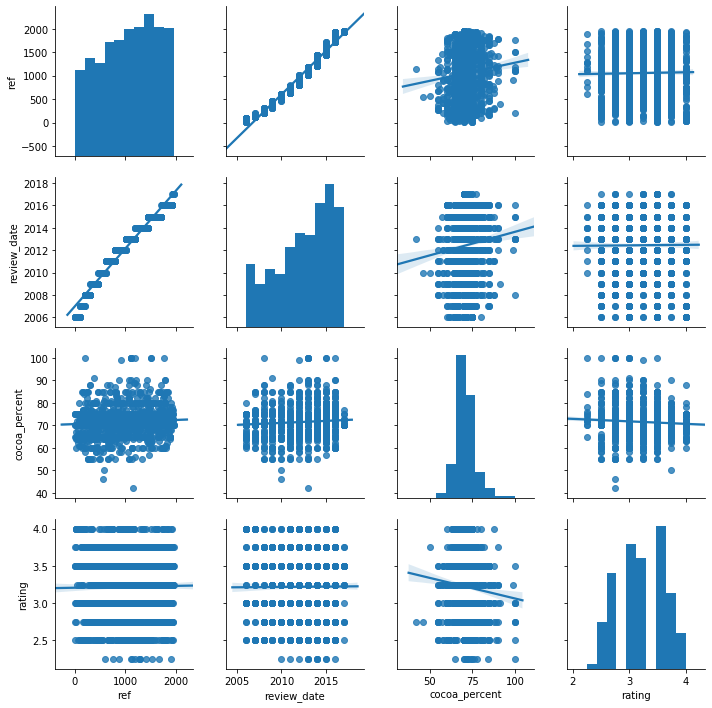

In [70]:
sns.pairplot(cacao, kind = 'reg')

In [71]:
# Используем для наглядности матрицу корреляций:

cacao.corr()

,ref,review_date,cocoa_percent,rating
ref,1.000000,0.984913,0.083765,0.016189
review_date,0.984913,1.000000,0.086523,0.006703
cocoa_percent,0.083765,0.086523,1.000000,-0.078156
rating,0.016189,0.006703,-0.078156,1.000000


Так как переменные review_date и ref скоррелированы почти полностью, одну переменную можно исключить. Пусть это будет переменная REF.

Останутся две слабоскоррелированные с рейтингом переменные: cocoa_percent и review_date.

Интересно, что положительная корреляция параметра review_date и rating может говорить как о том, что со временем батончики действительно становятся лучше, так и о том, что рейтинги просто завышаются.

Очевидно, что для номинативных переменных использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

Номинативные переменные, которые осталось рассмотреть: company, specific_origin, company_location, bean_type, broad_origin.

Так как уникальных значений в столбцах достаточно много, будем брать в рассмотрение по, например, 10 самых частотных.

In [72]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

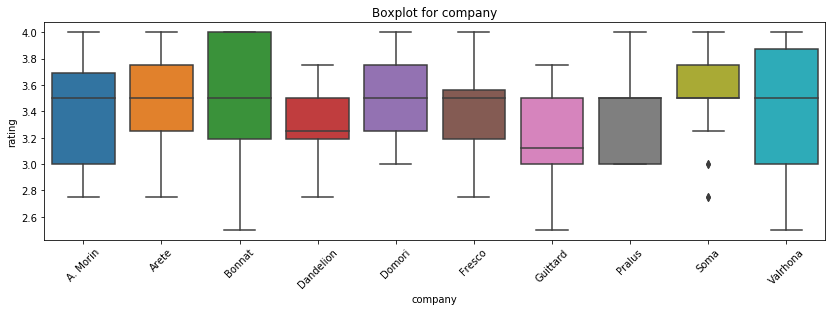

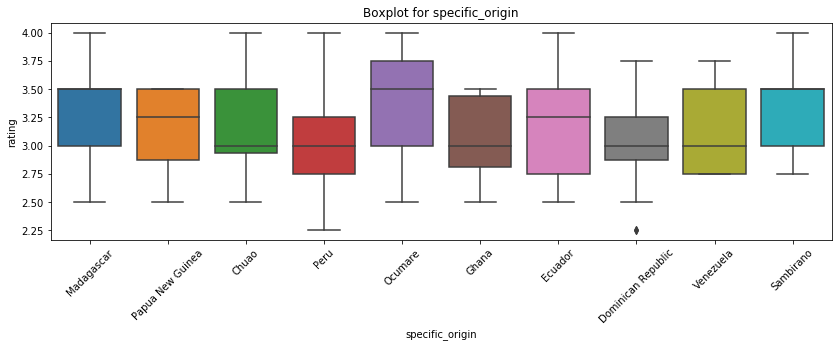

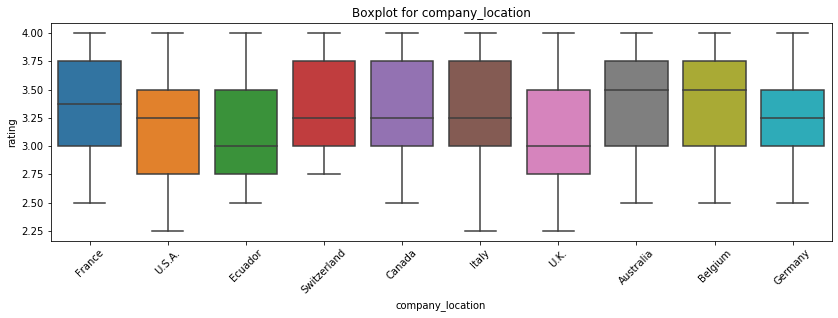

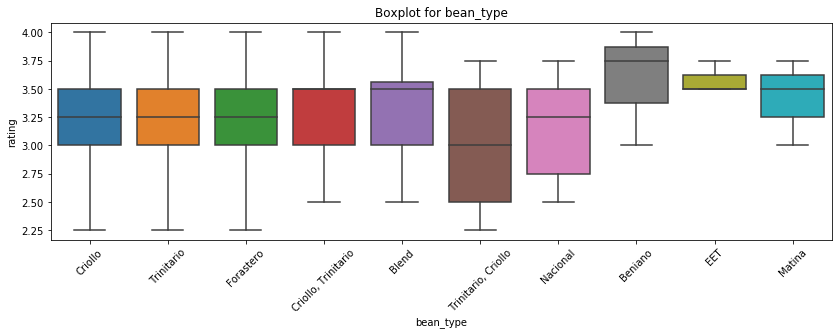

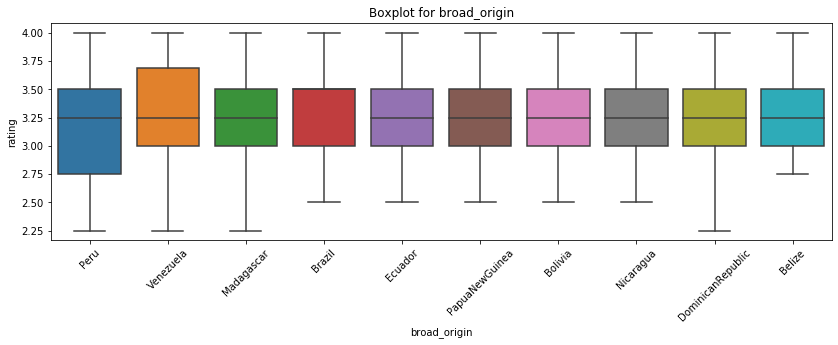

In [73]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot(col)

По графикам похоже, что все параметры, кроме broad_origin, могут влиять на оценку батончика. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:

In [76]:
def get_stat_dif(column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'rating'], 
                        cacao.loc[cacao.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки:', column)
            break

In [77]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки: company
Найдены статистически значимые различия для колонки: specific_origin
Найдены статистически значимые различия для колонки: company_location


Как мы видим, серьёзно отличаются три параметра: company,  specific_origin и  company_location. Оставим эти переменные в датасете для дальнейшего построения модели. Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это: company, specific_origin, company_location, review_date, cocoa_percent.

In [78]:
cacao_for_model = cacao.loc[:, ['company', 'specific_origin', 'company_location', 'review_date', 'cocoa_percent']]
cacao_for_model.head()

,company,specific_origin,company_location,review_date,cocoa_percent
1,A. Morin,Kpime,France,2015,70.0
3,A. Morin,Akata,France,2015,70.0
4,A. Morin,Quilla,France,2015,70.0
5,A. Morin,Carenero,France,2014,70.0
6,A. Morin,Cuba,France,2014,70.0


Итак, в результате EDA для анализа влияния параметров шоколада на экспертную оценку шоколадных батончиков были получены следующие выводы:

В данных достаточно мало пустых значений, только столбец bean_type был заполнен в малом количестве случаев.
Выбросы найдены только в столбцах с рейтингом и содержанием какао в шоколаде батончиков, что позволяет сделать вывод о том, что данные достаточно чистые.
Положительная корреляция параметра review_date и rating может говорить о том, что с годами рейтинги потихоньку завышаются, либо батончики становятся лучше.
Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это company, specific_origin, company_location, review_date и cocoa_percent.